# global variables

In [1]:
# data options
INPUT_IMAGE_SHAPE = (480, 640)
NUMBER_OF_CLASSES = 4

# tensorflow options
BATCH_SIZE = 16
SEED = 1993

# dependecies

In [2]:
import tensorflow as tf
tf.random.set_seed(SEED)
tf.keras.backend.clear_session()

import json
import ssdseglib
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

# default bounding boxes

In [3]:
# create default bounding boxes
boxes_default = ssdseglib.boxes.DefaultBoundingBoxes(
    feature_maps_shapes=((30, 40), (15, 20), (8, 10), (4, 5)),
    centers_padding_from_borders_percentage=0.025,
    boxes_scales=(0.2, 0.9),
    additional_square_box=True,  
)

# rescale default bounding boxes to input image shape
boxes_default.rescale_boxes_coordinates(image_shape=INPUT_IMAGE_SHAPE)

# input data

## load metadata

In [4]:
# test
with open('data/test.json', 'r') as f:
    path_images_test, path_masks_test, path_labels_boxes_test = map(list, zip(*json.load(f)))

## data encoder

In [5]:
# create a data reader encoder
data_reader_encoder = ssdseglib.datacoder.DataEncoderDecoder(
    num_classes=NUMBER_OF_CLASSES,
    image_shape=INPUT_IMAGE_SHAPE,
    xmin_boxes_default=boxes_default.get_boxes_coordinates_xmin(coordinates_style='ssd'),
    ymin_boxes_default=boxes_default.get_boxes_coordinates_ymin(coordinates_style='ssd'),
    xmax_boxes_default=boxes_default.get_boxes_coordinates_xmax(coordinates_style='ssd'),
    ymax_boxes_default=boxes_default.get_boxes_coordinates_ymax(coordinates_style='ssd'),
    iou_threshold=0.5,
    standard_deviations_centroids_offsets=(0.1, 0.1, 0.2, 0.2),
    augmentation_horizontal_flip=True
)

# model

## load weights

In [25]:
# load model
model = tf.keras.models.load_model(
    filepath='C:/Users/FOM5CER/git-repo-personal/ssd-segmentation/data/models/mymodel.keras',
    compile=False
)

# predictions

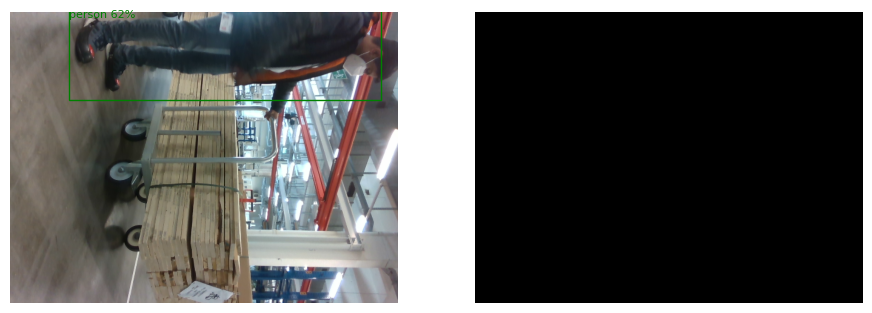

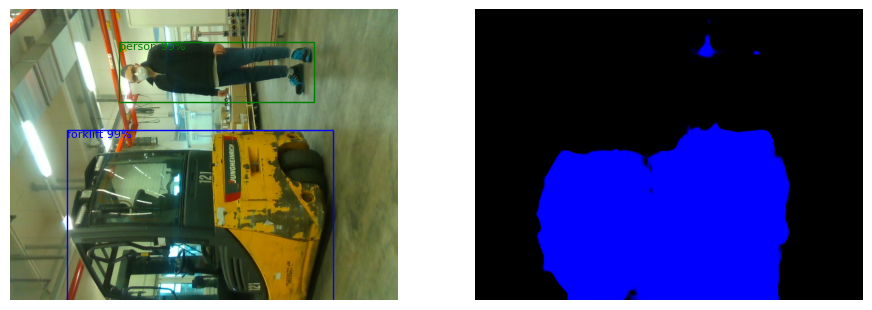

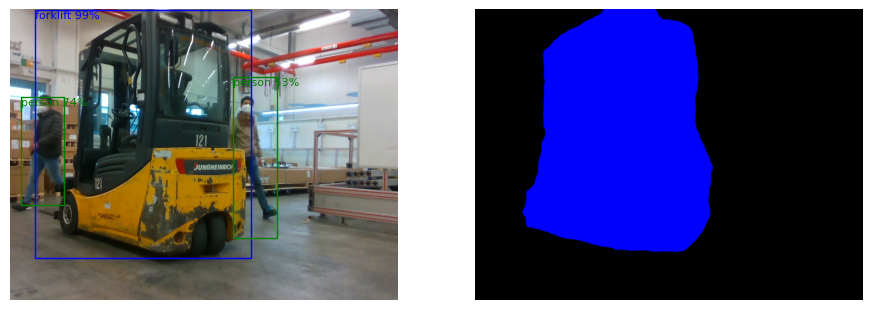

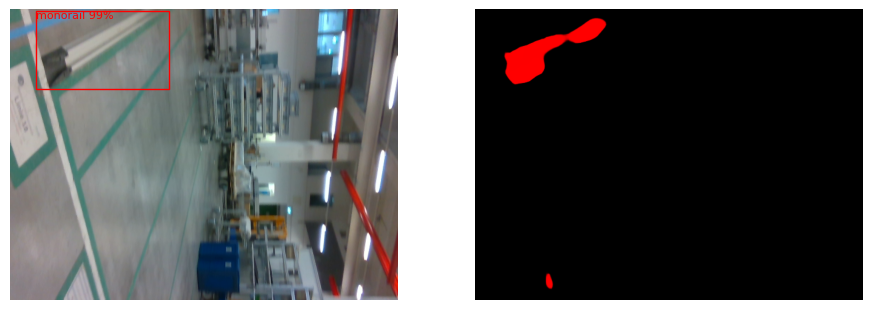

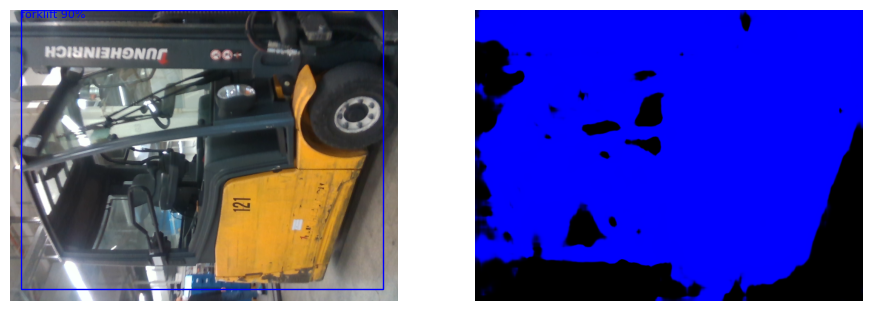

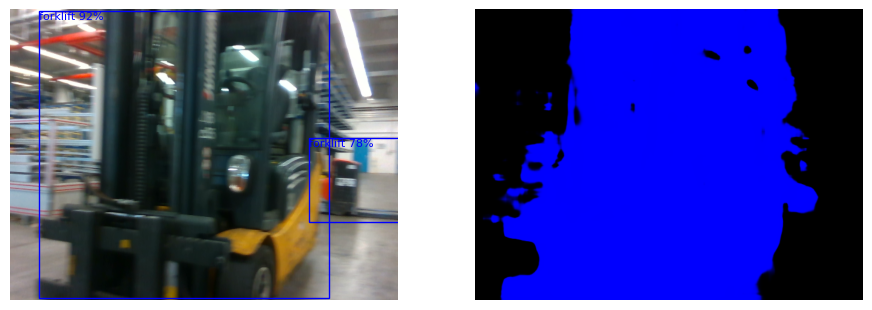

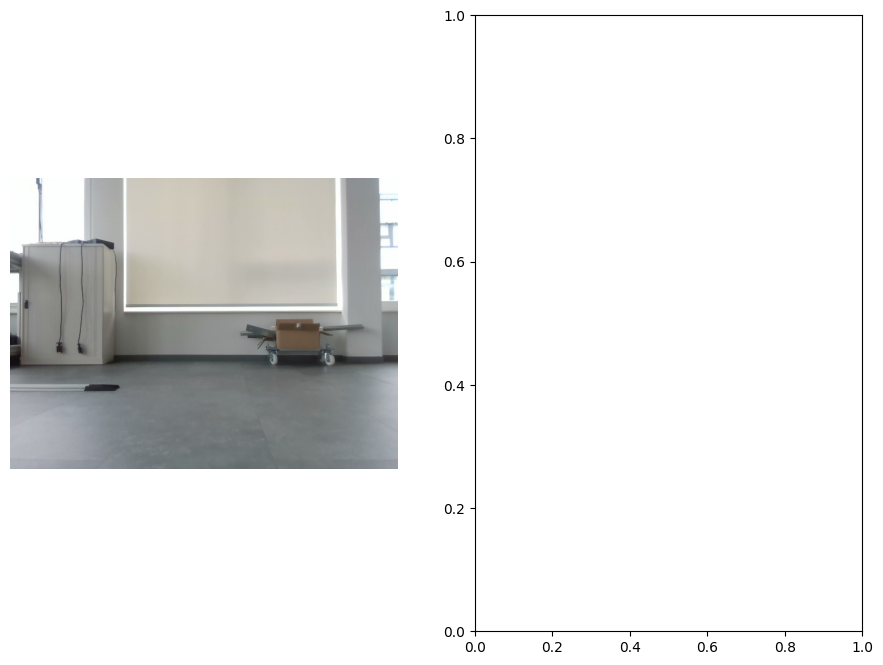

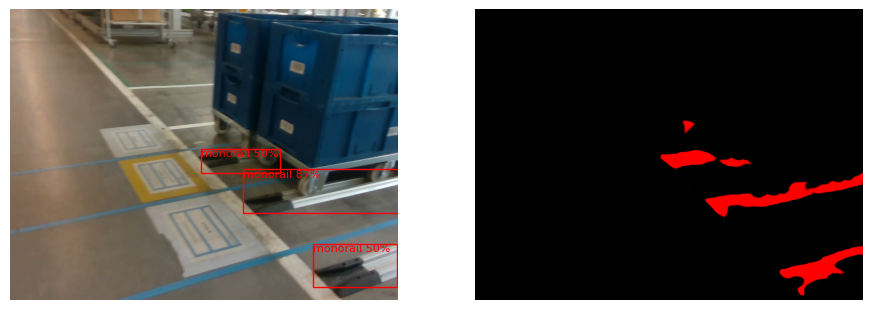

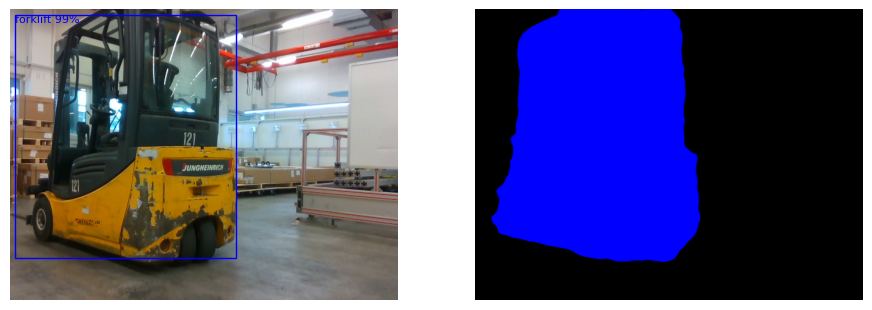

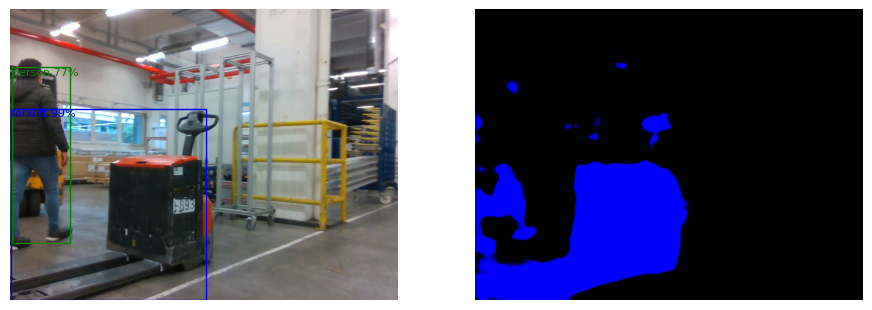

In [220]:
shuffled_indices = np.arange(len(path_images_test))
np.random.shuffle(shuffled_indices)

path_images_test = np.array(path_images_test)[shuffled_indices]
path_masks_test = np.array(path_masks_test)[shuffled_indices]
path_labels_boxes_test = np.array(path_labels_boxes_test)[shuffled_indices]

for path_image, path_mask, path_labels_boxes in zip(path_images_test[:10], path_masks_test[:10], path_labels_boxes_test[:10]):
    image = Image.open(path_image)
    image_batch = np.array(image).astype(np.float32)
    image_batch = np.expand_dims(image, axis=0)

    mask, labels_probs, boxes_offsets = model(image_batch, training=False)
    boxes_offsets = tf.squeeze(boxes_offsets, axis=0)
    decoded_boxes = data_reader_encoder.decode_to_corners(offsets_centroids=boxes_offsets)
    decoded_boxes = tf.expand_dims(decoded_boxes, axis=0)

    max_output_size = 5
    max_total_size = 10
    iou_threshold = 0.5
    score_threshold = 0.5

    nms_boxes, nms_scores, nms_classes, num_detections = tf.image.combined_non_max_suppression(
        boxes=tf.expand_dims(tf.gather(decoded_boxes, indices=[1, 0, 3, 2], axis=-1), axis=2),
        scores=labels_probs,
        max_output_size_per_class=max_output_size,
        max_total_size=max_total_size,
        iou_threshold=iou_threshold,
        score_threshold=score_threshold,
        clip_boxes=False
    )

    # selected_boxes = tf.gather(boxes, selected_indices[0])
    not_background = tf.math.greater(nms_classes, 0)
    nms_classes = tf.boolean_mask(nms_classes, not_background)
    nms_scores = tf.boolean_mask(nms_scores, not_background)
    nms_boxes = tf.boolean_mask(nms_boxes, not_background)

    from matplotlib import patches
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 8))
         

    # labels conversions
    label_code_to_str = {
        0: 'background',
        1: 'monorail',
        2: 'person',
        3: 'forklift'
    }
    label_code_to_color = {
        0: 'white',
        1: 'red',
        2: 'green',
        3: 'blue'
    }

    ax1.set_aspect('equal')
    ax1.imshow(image, vmin=0, vmax=255)
    ax1.set_axis_off()

    if nms_classes.ndim == 0:
        nms_classes = tf.expand_dims(nms_classes, axis=0)
        nms_scores = tf.expand_dims(nms_scores, axis=0)
        nms_boxes = tf.expand_dims(nms_boxes, axis=0)

    for label, label_prob, (ymin, xmin, ymax, xmax) in zip(nms_classes, nms_scores, nms_boxes):
        label = int(label)
        label_prob = float(label_prob)
        xmin = float(xmin)
        ymin = float(ymin)
        xmax = float(xmax)
        ymax = float(ymax)        
        rect = patches.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, linewidth=1, edgecolor=label_code_to_color[label], facecolor='none')
        ax1.add_patch(rect)
        ax1.text(xmin, ymin, label_code_to_str[label] + f' {int(label_prob*100)}%', fontsize=8, color=label_code_to_color[label], verticalalignment='top')        

        mask_sample = tf.slice(tf.squeeze(mask, axis=0), begin=[0, 0, 1], size=[-1, -1, 3])

        # setup the subplot
        ax2.set_aspect('equal')
        ax2.imshow(mask_sample, vmin=0.0, vmax=1.0)
        ax2.set_axis_off()

    plt.show()